<a href="https://colab.research.google.com/github/adrinorosario/stellar-and-galactic-object-classification/blob/main/SDSS_modeling_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling experiments

In this notebook, we will aim to build machine learning models that detect and classify an object as a star, galaxy or a quasar. A set of three different train and test splits have already been prepared. The aim of this notebook is to conduct, test and arrive at the best performing model for the task of stellar and galactic object classification using photometric and spectral data.

## 1. Build baseline model

In this section, we will build a baseline model on the two datasets and then conduct $F_1$ evaluations to compare and determine the effect of each dataset in classification.

A set of different train and test splits with the following train-to-test ratios have already been created:

* 80:20
* 67:33
* 90:10

For our baseline experiment, we will go with the 80:20 ratio.

In [ ]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/sdss_15k_sample.csv")
df = df.drop(['objID', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'ra', 'dec', 'type'], axis=1)
df.columns

features = df.drop(["class"], axis=1)
features.columns

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'u_g', 'g_r', 'r_i', 'i_z'], dtype='object')

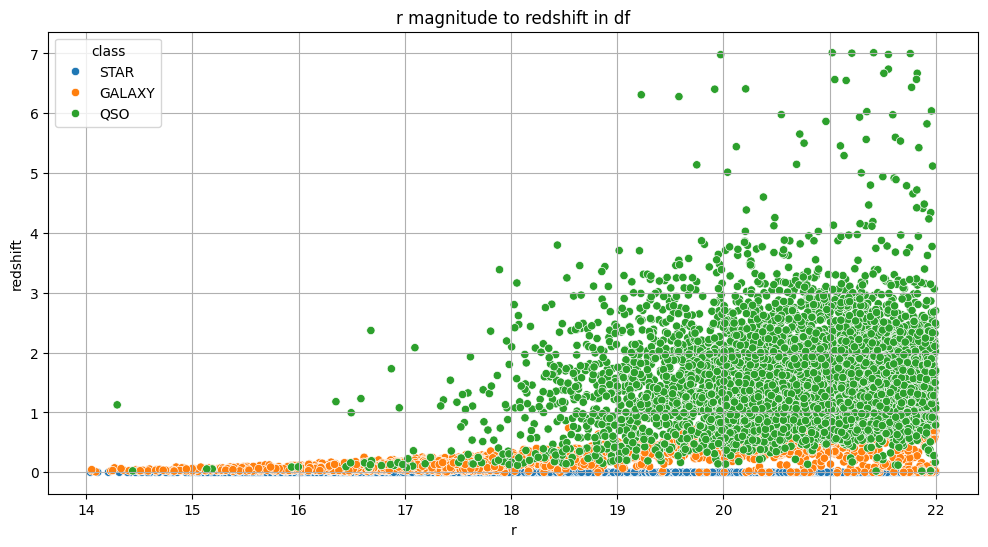

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="r", y="redshift", hue="class")
plt.title("r magnitude to redshift in df")
plt.grid()

We confirm that our first dataset has objects with varied brightness.

In [ ]:
# load the splits
import joblib

loaded_splits = joblib.load("/content/drive/MyDrive/sdss_5000_train_test_split_80.joblib")

In [ ]:
X_train1 = loaded_splits[0]
y_train1 = loaded_splits[2]

X_test1 = loaded_splits[1]
y_test1 = loaded_splits[3]

In [ ]:
X_train1.shape[0] == y_train1.shape[0], X_test1.shape[0] == y_test1.shape[0]

(True, True)

**Note:** The above loaded dataset does not any scaling applied to it. We will first train our decision tree baseline model, which is invariant to any feature transformations. Later when using distance models, we will apply feature transformations.

In [ ]:
from sklearn import tree

We will set the max depth of the tree to be 3 for our first round of experiments and have a "best" split for our data. The depth is chosen to be 3 because we do not have very complex features in our data yet and it is a relatively smaller dataset.

In [ ]:
dt_clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, splitter="best")
dt_clf.fit(X=X_train1, y=y_train1)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [ ]:
dt1_score = dt_clf.score(X_test1, y_test1)

In [ ]:
print(f"Score of dt_clf on the dataset not ordered by r magnitude: {dt1_score}")

Score of dt_clf on the dataset not ordered by r magnitude: 0.9626666666666667


We get a very good accuracy score for our first test.

In [ ]:
y_pred = dt_clf.predict(X_test1)

dt1_f1score = metrics.f1_score(y_true=y_test1, y_pred=y_pred, average="macro")

Let us plot a confusion matrix to evaluate the classification.

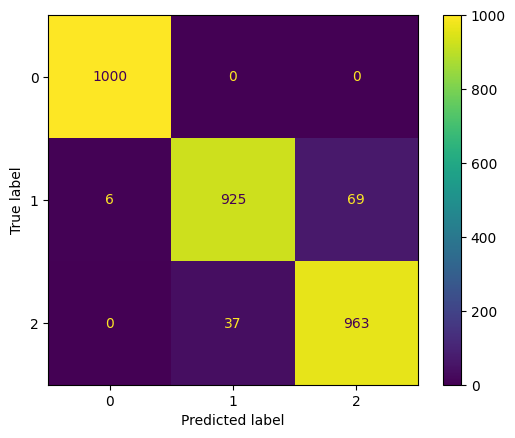

In [ ]:
conf_mat1 = metrics.confusion_matrix(y_test1, y_pred, labels=dt_clf.classes_)
disp = metrics.ConfusionMatrixDisplay(conf_mat1, display_labels=dt_clf.classes_)
disp.plot()

We can see that star objects were classified with the highest accuracy with quasars coming behind them and then galaxies.

In [ ]:
print(f"F1 score for dt_clf1 on unordered dataset with a wide range of magnitudes: {dt1_f1score}")

F1 score for dt_clf1 on unordered dataset with a wide range of magnitudes: 0.9625863370689086


Our $F_1$ score is also higher enough to obtain a good performing baseline model. Now, we will get a classification report and derive the associated graph of our model.

In [ ]:
target_names = ["class 0", "class 1", "class 2"]

In [ ]:
dt1_classification_report = metrics.classification_report(y_test, y_pred, target_names=target_names)
print(dt1_classification_report)

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      1000
     class 1       0.96      0.93      0.94      1000
     class 2       0.93      0.96      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



From the generated classification report for `dt_clf`, we can see that the $F_1$ score for stars is higher than that of the other two, with quasars having higher score than galaxies. The accuracy is even for all the classes.

In [ ]:
!pip install graphviz

In [ ]:
def get_tree_graph(dt: sklearn.tree, labels: list, features=pd.DataFrame, name: str="dt-graph"):
  """Returns the associated graph of the decision tree passed in.

  Constructs a graph of the decision tree for the features and labels passed in
  using the graphviz library and returns it.

  Args:
      dt: The decision tree model from scikit-learn.
      labels: A list of the class labels that need to be predicted.
      features: A pandas dataframe with the features used for prediction.
      name: A name for your output graph.

  Returns:
      A graphviz object (as a graph)
  """

  labels.sort()

  dot_data = tree.export_graphviz(dt, out_file=None,
                                feature_names=features.columns.to_list(),
                                class_names=[str(x) for x in labels],
                                filled=True, rounded=True,
                                special_characters=True)

  graph = graphviz.Source(dot_data)
  graph.render(name)
  return graph

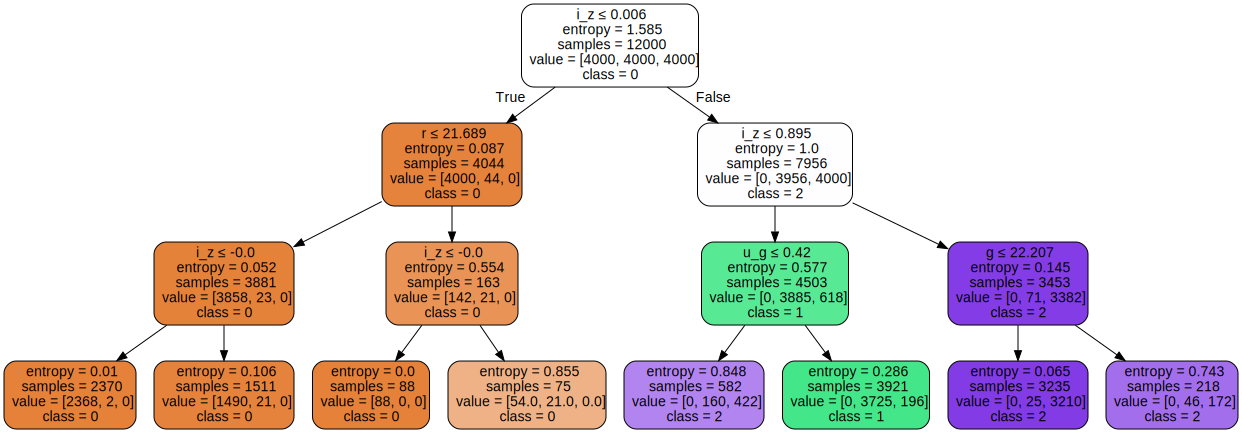

In [ ]:
get_tree_graph(dt=dt_clf, labels=[0, 1, 2], features=features, name="dt_1_graph")

Now, we will perform the same baseline testing for the dataset ordered by `r` magnitude where the proportion of less brighter objects is higher than that of our previous set.

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/sdss_15k_sample2.csv")

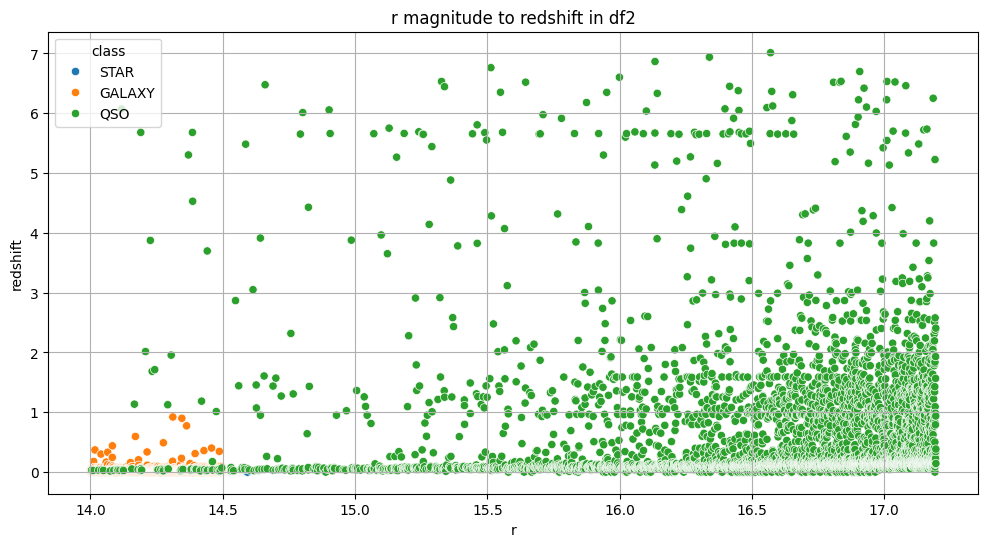

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df2, x="r", y="redshift", hue="class")
plt.title("r magnitude to redshift in df2")
plt.grid()

We can confirm that our second dataset is more biased towards less brighter objects with only quasars and a few galaxies being more brighter than the rest of the objects.

In [ ]:
encoder = {
    "STAR": 0,
    "GALAXY": 1,
    "QSO": 2
}

df2["class"] = df2["class"].map(encoder)

In [ ]:
X = df2.drop(["class"], axis=1)
y = df2["class"]

We will use the same stratified testing strategy for this dataset as well.

In [ ]:
loaded_splits_2 = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train2, X_test2, y_train2, y_test2 = loaded_splits

print(f"Training features set has {X_train2.shape[0]} rows with {X_train2.shape[1]} columns")
print(f"Training labels set has {y_train2.shape[0]} rows\n")

print(f"Testing features set has {X_test2.shape[0]} rows with {X_test2.shape[1]} columns")
print(f"Testing labels set has {y_test2.shape[0]} rows")

Training features set has 12000 rows with 10 columns
Training labels set has 12000 rows

Testing features set has 3000 rows with 10 columns
Testing labels set has 3000 rows


In [ ]:
X_train2.shape[0] == y_train2.shape[0], X_test2.shape[0] == y_test2.shape[0]

(True, True)

The model hyperparameters remain the same as that of `dt_clf`.

In [ ]:
dt_clf2 = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=3)
dt_clf2.fit(X_train2, y_train2)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [ ]:
dt2_score = dt_clf2.score(X_test2, y_test2)

In [ ]:
print(f"Accuracy score of dt_clf2 with less brighter objects: {dt2_score}")

Accuracy score of dt_clf2 with less brighter objects: 0.9626666666666667


The accuracy score seems to be the same as that of our first model.

In [ ]:
y_pred = dt_clf2.predict(X_test2)

dt2_f1score = metrics.f1_score(y_true=y_test2, y_pred=y_pred, average="macro")

In [ ]:
print(f"Accuracy score of dt_clf2: {dt2_f1score}")

Accuracy score of dt_clf2: 0.9625863370689086


Even the $F_1$ score is very similar to that obtained from `dt_clf`. Let us plot a confusion matrix and check the accuracy of our classification.

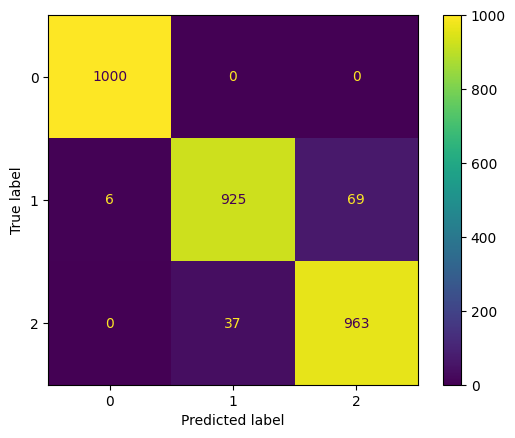

In [ ]:
conf_mat2 = metrics.confusion_matrix(y_test2, y_pred, labels=dt_clf2.classes_)
disp = metrics.ConfusionMatrixDisplay(conf_mat2, display_labels=dt_clf2.classes_)
disp.plot()

From the above plot, we can see that star objects were classified with the highest accuracy, with quasars coming second and galaxies third.

In [ ]:
dt2_classification_report = metrics.classification_report(y_test, y_pred, target_names=target_names)
print(dt2_classification_report)

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      1000
     class 1       0.96      0.93      0.94      1000
     class 2       0.93      0.96      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



From the above classification report, we can observe that both the models share similar characterisitcs and performance metrics.

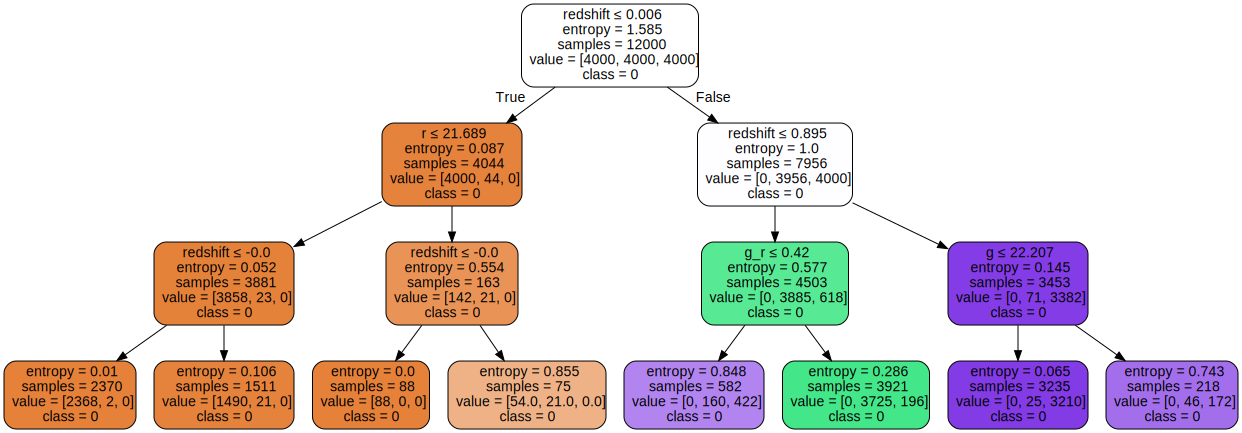

In [ ]:
get_tree_graph(dt=dt_clf2, labels=list(y), features=X, name="dt_clf2_graph")

For testing purposes, we will interchange the test splits for both the baselines models and check their performance on new data.

In [ ]:
y_pred = dt_clf.predict(X_test2)

print(metrics.classification_report(y_test2, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      1000
     class 1       0.96      0.93      0.94      1000
     class 2       0.93      0.96      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
y_pred = dt_clf2.predict(X_test1)

print(metrics.classification_report(y_test1, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      1000
     class 1       0.96      0.93      0.94      1000
     class 2       0.93      0.96      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



From the above experiment, we can see that both the models perform exactly the same when they are tested on new data. This is a good start in our model testing experiment.

### Summary from baseline modeling experiments

We used two different datasets - one with a broader range of bright objects not confined to less or high bright objects dominating the dataset space and, the other with relatively less brighter objects with only quasars and a few galaxies being brighter than the rest.

We did not apply any scaling as we used Decision Trees which are invariant to any feature transformations.

Two different models were trained on the two different datasets. Each performed similar to the other and achieved a very high and similar accuracy and $F_1$ score. To further confirm that these models could work on new data, the test splits were interchanged and tested with the opposite models. This also yielded a similar high score in accuracy and $F_1$ score.

Therefore, from the above baseline experiments, we can say that the bias towards less brighter objects does not affect the model from classifying the objects accurately. The extreme bright objects are not memorized and the decision tree classifier performs extremely well in both the cases.

## Moving to a larger dataset

In this section, we will aim to achieve a good classification accuracy with a larger dataset. This dataset comprises of $\sim4\ million$ stellar and galactic object records queried from the SDSS SkyServer database using a CASJob. We will carry out some necessary EDA to derive some intuition of the data we are working with and try to fit 3 different models and arrive at the best performing model.

In [ ]:
# load dataset into dataframe
df = pd.read_csv("/content/SDSS5mSample_adrino.csv")
df.head(5)

,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,type,class,subclass
0,22.80583,21.87576,20.14159,19.25278,18.86618,0.522415,23.47196,22.62187,20.84825,20.01149,19.57170,22.80583,21.87576,20.14159,19.25278,18.86618,3,GALAXY,NaN
1,24.08731,23.38522,21.09559,19.76715,19.36116,0.660371,23.97463,23.69705,21.71613,20.42897,19.92269,24.08731,23.38522,21.09559,19.76715,19.36116,3,GALAXY,NaN
2,23.06120,21.93787,20.19050,19.21400,18.68582,0.506030,23.83158,22.63002,20.97228,20.03491,19.47176,23.06120,21.93787,20.19050,19.21400,18.68582,3,GALAXY,NaN
3,23.43807,21.80152,20.18627,19.39642,18.83888,0.444314,23.80578,22.77928,21.16769,20.45187,19.85043,23.43807,21.80152,20.18627,19.39642,18.83888,3,GALAXY,NaN
4,23.37766,22.11548,20.24511,19.32709,18.89241,0.537600,23.71419,22.73792,20.86832,20.04706,19.52490,23.37766,22.11548,20.24511,19.32709,18.89241,3,GALAXY,NaN


We will drop the `subclass` column.

In [ ]:
df = df.drop(["subclass"], axis=1)
df.shape

(4338926, 18)

In [ ]:
df["class"].value_counts()

,count
class,
GALAXY,2591604
STAR,925295
QSO,822027


There is definitely imbalance in our dataset with galaxies dominataing ans then stars and quasars being almost equal but lesser than that of galaxies. Regardless, we will work with this imabalanced dataset.

In [ ]:
df.loc[df["class"] == "STAR", 'u_g'] = df["psfMag_u"] - df["psfMag_g"]
df.loc[df["class"] == "STAR", 'g_r'] = df["psfMag_g"] - df["psfMag_r"]
df.loc[df["class"] == "STAR", 'r_i'] = df["psfMag_r"] - df["psfMag_i"]
df.loc[df["class"] == "STAR", 'i_z'] = df["psfMag_i"] - df["psfMag_z"]

df.loc[df["class"] == "GALAXY", 'u_g'] = df["modelMag_u"] - df["modelMag_g"]
df.loc[df["class"] == "GALAXY", 'g_r'] = df["modelMag_g"] - df["modelMag_r"]
df.loc[df["class"] == "GALAXY", 'r_i'] = df["modelMag_r"] - df["modelMag_i"]
df.loc[df["class"] == "GALAXY", 'i_z'] = df["modelMag_i"] - df["modelMag_z"]

df.loc[df["class"] == "QSO", 'u_g'] = df["psfMag_u"] - df["psfMag_g"]
df.loc[df["class"] == "QSO", 'g_r'] = df["psfMag_g"] - df["psfMag_r"]
df.loc[df["class"] == "QSO", 'r_i'] = df["psfMag_r"] - df["psfMag_i"]
df.loc[df["class"] == "QSO", 'i_z'] = df["psfMag_i"] - df["psfMag_z"]

In [ ]:
df.head(5)

,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,psfMag_i,...,modelMag_g,modelMag_r,modelMag_i,modelMag_z,type,class,u_g,g_r,r_i,i_z
0,22.80583,21.87576,20.14159,19.25278,18.86618,0.522415,23.47196,22.62187,20.84825,20.01149,...,21.87576,20.14159,19.25278,18.86618,3,GALAXY,0.93007,1.73417,0.88881,0.38660
1,24.08731,23.38522,21.09559,19.76715,19.36116,0.660371,23.97463,23.69705,21.71613,20.42897,...,23.38522,21.09559,19.76715,19.36116,3,GALAXY,0.70209,2.28963,1.32844,0.40599
2,23.06120,21.93787,20.19050,19.21400,18.68582,0.506030,23.83158,22.63002,20.97228,20.03491,...,21.93787,20.19050,19.21400,18.68582,3,GALAXY,1.12333,1.74737,0.97650,0.52818
3,23.43807,21.80152,20.18627,19.39642,18.83888,0.444314,23.80578,22.77928,21.16769,20.45187,...,21.80152,20.18627,19.39642,18.83888,3,GALAXY,1.63655,1.61525,0.78985,0.55754
4,23.37766,22.11548,20.24511,19.32709,18.89241,0.537600,23.71419,22.73792,20.86832,20.04706,...,22.11548,20.24511,19.32709,18.89241,3,GALAXY,1.26218,1.87037,0.91802,0.43468


In [ ]:
df.columns

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'psfMag_u', 'psfMag_g', 'psfMag_r',
       'psfMag_i', 'psfMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r',
       'modelMag_i', 'modelMag_z', 'type', 'class', 'u_g', 'g_r', 'r_i',
       'i_z'],
      dtype='object')

In [ ]:
df = df.drop(['psfMag_u', 'psfMag_g', 'psfMag_r',
       'psfMag_i', 'psfMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r',
       'modelMag_i', 'modelMag_z', 'type'], axis=1)
df.columns

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'class', 'u_g', 'g_r', 'r_i',
       'i_z'],
      dtype='object')

In [ ]:
df.isna().sum()

,0
u,0
g,0
r,0
i,0
z,0
redshift,0
class,0
u_g,0
g_r,0
r_i,0


In [ ]:
encoder = {
    "STAR": 0,
    "GALAXY": 1,
    "QSO": 2
}

df["class"] = df["class"].map(encoder)
df["class"].head(5)

,class
0,1
1,1
2,1
3,1
4,1


In [ ]:
df.describe()

,u,g,r,i,z,redshift,class,u_g,g_r,r_i,i_z
count,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06,4.338926e+06
mean,2.188350e+01,2.039153e+01,1.945425e+01,1.887817e+01,1.856093e+01,5.591429e-01,9.761996e-01,1.463894e+00,9.318000e-01,5.753829e-01,3.243496e-01
std,2.895271e+01,2.641974e+01,1.756034e+00,1.931075e+01,2.262106e+01,7.233334e-01,6.341467e-01,1.670269e+01,2.635187e+01,1.862935e+01,2.306296e+01
min,-9.999000e+03,-9.999000e+03,1.400011e+01,-9.999000e+03,-9.999000e+03,-1.144691e-02,0.000000e+00,-1.002020e+04,-1.001952e+04,-1.595220e+01,-1.001826e+04
25%,2.020835e+01,1.877626e+01,1.790059e+01,1.751206e+01,1.726235e+01,5.737008e-02,1.000000e+00,6.767800e-01,3.888600e-01,2.120525e-01,1.446700e-01
50%,2.201073e+01,2.093479e+01,1.996173e+01,1.927293e+01,1.888524e+01,3.934992e-01,1.000000e+00,1.351530e+00,9.604700e-01,4.694400e-01,3.372900e-01
75%,2.356894e+01,2.197243e+01,2.086246e+01,2.014132e+01,1.975022e+01,6.484203e-01,1.000000e+00,2.049180e+00,1.589600e+00,8.691300e-01,4.606400e-01
max,3.345042e+01,3.290944e+01,2.200000e+01,3.214147e+01,3.072386e+01,7.051930e+00,2.000000e+00,1.002189e+04,1.563844e+01,1.002372e+04,1.001871e+04


In [ ]:
df["redshift"].describe()

,redshift
count,4.338926e+06
mean,5.591429e-01
std,7.233334e-01
min,-1.144691e-02
25%,5.737008e-02
50%,3.934992e-01
75%,6.484203e-01
max,7.051930e+00


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df[["redshift"]])

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
normalized_redshift = scaler.transform(df[["redshift"]])
normalized_redshift = np.round(normalized_redshift, decimals=3)
pd.Series(normalized_redshift.reshape(-1))

,0
0,-0.849
1,-0.810
2,-0.853
3,-0.871
4,-0.845
...,...
4338921,-0.997
4338922,-0.997
4338923,-0.997
4338924,-0.998


In [ ]:
pd.Series(normalized_redshift.reshape(-1)).describe()

,0
count,4.338926e+06
mean,-8.384808e-01
std,2.048460e-01
min,-1.000000e+00
25%,-9.810000e-01
50%,-8.850000e-01
75%,-8.130000e-01
max,1.000000e+00


In [ ]:
df["redshift"] = normalized_redshift

In [ ]:
df.head(3)

,u,g,r,i,z,redshift,class,u_g,g_r,r_i,i_z
0,22.80583,21.87576,20.14159,19.25278,18.86618,-0.849,1,0.93007,1.73417,0.88881,0.38660
1,24.08731,23.38522,21.09559,19.76715,19.36116,-0.810,1,0.70209,2.28963,1.32844,0.40599
2,23.06120,21.93787,20.19050,19.21400,18.68582,-0.853,1,1.12333,1.74737,0.97650,0.52818


In [ ]:
X = df.drop(["class"], axis=1)
y = df["class"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42
)

print(f"Training features set has {X_train.shape[0]} rows with {X_train.shape[1]} columns")
print(f"Training labels set has {y_train.shape[0]} rows\n")

print(f"Testing features set has {X_test.shape[0]} rows with {X_test.shape[1]} columns")
print(f"Testing labels set has {y_test.shape[0]} rows")

Training features set has 2907080 rows with 10 columns
Training labels set has 2907080 rows

Testing features set has 1431846 rows with 10 columns
Testing labels set has 1431846 rows


In [ ]:
dt_clf3 = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, splitter="best")
dt_clf3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [ ]:
dt_clf3_score = dt_clf3.score(X_test, y_test)
print(f"Accuracy score of dt_clf3 with best split and depth of 3: {dt_clf3_score}")

Accuracy score of dt_clf3 with best split and depth of 3: 0.9614665264281215


In [ ]:
y_pred_dtclf3 = dt_clf3.predict(X_test)

dt_clf3_f1_score = metrics.f1_score(y_test, y_pred_dtclf3, average="macro")
print(f"F1 score of dt_clf3: {dt_clf3_f1_score}")

F1 score of dt_clf3: 0.9566288308112475


In [ ]:
dt_clf3_classification_report = metrics.classification_report(y_test, y_pred_dtclf3, target_names=target_names)
print(dt_clf3_classification_report)

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99    305347
     class 1       0.98      0.95      0.97    855230
     class 2       0.88      0.94      0.91    271269

    accuracy                           0.96   1431846
   macro avg       0.95      0.97      0.96   1431846
weighted avg       0.96      0.96      0.96   1431846



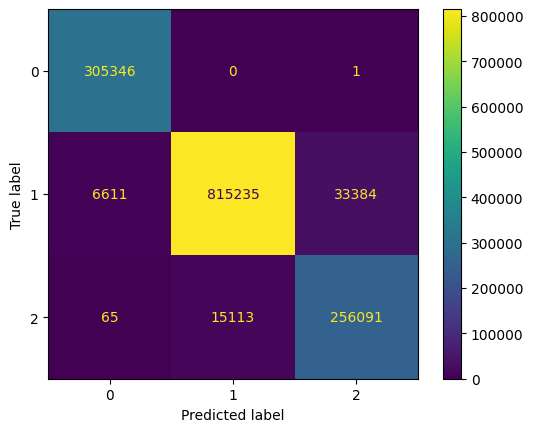

In [ ]:
conf_mat3 = metrics.confusion_matrix(y_test, y_pred_dtclf3, labels=dt_clf3.classes_)
disp = metrics.ConfusionMatrixDisplay(conf_mat3, display_labels=dt_clf3.classes_)
disp.plot()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc_1 = RandomForestClassifier(n_estimators=10, criterion="entropy", max_depth=3)
rfc_1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=10)

In [ ]:
rfc1_acc_score = rfc_1.score(X_test, y_test)
print(f"Accuracy score of Random Forest Classifier with 10 estimators and depth of 3 for each class: {rfc1_acc_score}")

Accuracy score of Random Forest Classifier with 10 estimators and depth of 3 for each class: 0.9638229250911061


In [ ]:
y_pred_rfc1 = rfc_1.predict(X_test)

rfc1_f1_score = metrics.f1_score(y_test, y_pred_rfc1, average="macro")
print(f"F1 score of rfc1: {rfc1_f1_score}")

F1 score of rfc1: 0.9585804874785723


In [ ]:
rfc1_classification_report = metrics.classification_report(y_test, y_pred_rfc1, target_names=target_names)
print(rfc1_classification_report)

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99    305347
     class 1       0.97      0.96      0.97    855230
     class 2       0.91      0.92      0.92    271269

    accuracy                           0.96   1431846
   macro avg       0.96      0.96      0.96   1431846
weighted avg       0.96      0.96      0.96   1431846



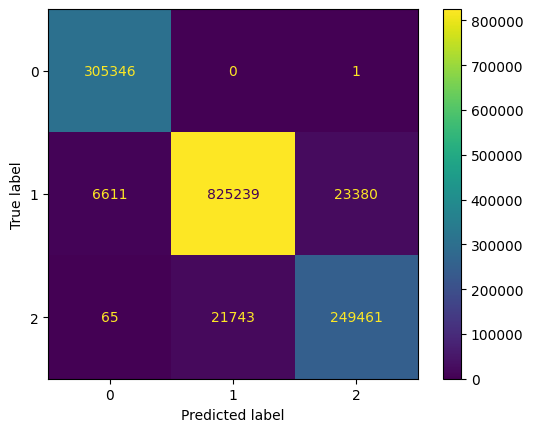

In [ ]:
conf_mat4 = metrics.confusion_matrix(y_test, y_pred_rfc1, labels=rfc_1.classes_)
disp = metrics.ConfusionMatrixDisplay(conf_mat4, display_labels=rfc_1.classes_)
disp.plot()

In [ ]:
import joblib

joblib.dump(dt_clf3, "/content/drive/MyDrive/dt_clf_on5Msample.joblib")
joblib.dump(rfc_1, "/content/drive/MyDrive/rfc1_on5Msample.joblib")

['/content/drive/MyDrive/rfc1_on5Msample.joblib']